In [22]:
import sys
sys.path.append('../src')

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from iecdt.data import geom
import geoplot as gplt
import numpy as np
from glob import glob
import pandas as pd
from joblib import Parallel, delayed
world = geom.get_world()
from IPython.display import Markdown

from tqdm import tqdm
from iecdt.genai import gemini, mistral
from importlib import reload



## read all embeddings

In [2]:
files = glob('/opt/data/dora/embeddings/consolidated/*')
def readf(fname):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
        
    return {k: z[k] for k in ['chip_id', 'image_embedding', 'text_embedding', 'lonlat']}

embs = Parallel(verbose=5, n_jobs=-1)(delayed(readf)(fname) for fname in files)
embs = pd.DataFrame(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4096 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 41472 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 48313 out of 48313 | elapsed:    3.1s finished


In [3]:
tembs = np.r_[[np.r_[i] for i in embs.text_embedding.values]]
iembs = np.r_[[np.r_[i] for i in embs.image_embedding.values]]

In [4]:
tembs.shape, iembs.shape

((48313, 1024), (48313, 1024))

## sample pairs and measure distances

In [28]:
def evaluate(tembs, iembs, n_samples=100000):
    distances = {'text_space':[], 'image_space':[]}
    
    for _ in tqdm(range(n_samples)):
        i,j = np.random.randint(len(tembs), size=2)
        tdist = np.sqrt(((tembs[i] - tembs[j])**2).sum())
        idist = np.sqrt(((iembs[i] - iembs[j])**2).sum())
        
        distances['text_space'].append(tdist)
        distances['image_space'].append(idist)
    
    return distances
    

In [29]:
distances = evaluate(tembs, iembs)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39253.67it/s]


In [6]:
a,b = np.percentile(distances['text_space'], (1,99))
distances['text_space'] = (np.r_[distances['text_space']] - a)/(b-a)
a,b = np.percentile(distances['image_space'], (1,99))
distances['image_space'] = (np.r_[distances['image_space']] - a)/(b-a)


(-0.1, 1.1)

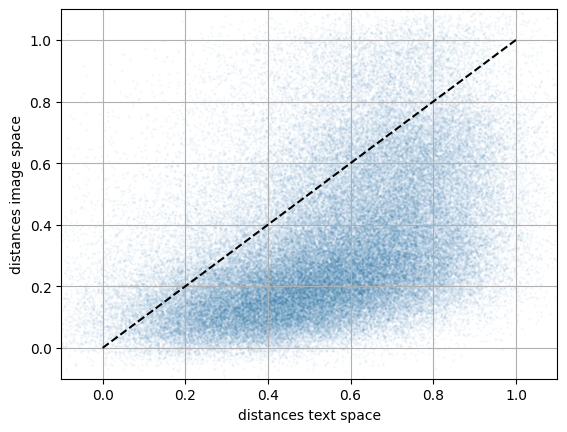

In [7]:
plt.scatter(distances['text_space'], distances['image_space'], s=1, alpha=.03)
plt.grid()
plt.xlabel('distances text space')
plt.ylabel('distances image space')
plt.plot([0,1],[0,1], color='black', ls='--')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

In [8]:
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

np.float64(0.44205074611703654)

## evaluate a description prompt with 10 sample images

- send to gemini to generate a description
- send to mistral to get the description text embeddings

In [37]:
generation_prompt =  """
describe this satellite image. 
include distinctive terrain features, natural and man made objects 
that will help relate this image to similar images and differentiate 
it from very different images
        """

In [38]:
gem = gemini.GeminiMultimodalModel(api_key='../../secrets/gemini.txt')
gem.set_generation_prompt(generation_prompt)

mistr = mistral.MistralEmbeddingsAPIModel(api_key='../../secrets/mistral.txt')


model mistral-embed configure for API calls


In [50]:
file = np.random.choice(files)
with open(file, 'rb') as f:
    z = pickle.load(f)
descr = gem.generate_description_for_image(z['img'])


**compare descriptions**

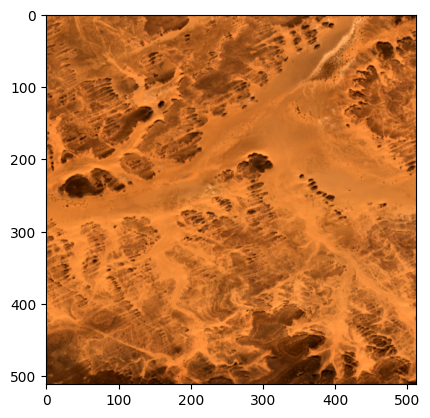

In [51]:
plt.imshow(z['img'])

In [52]:
print (descr)

This satellite image shows a vast, arid landscape, likely a desert, characterized by a uniform orange-brown hue suggesting sand or exposed rock. The terrain is textured and varied, exhibiting several key features:

* **Linear Ridges and Erosional Features:**  Numerous parallel or sub-parallel linear ridges and valleys are visible, likely formed by wind or water erosion. These features vary in size and prominence, creating a textured, almost wave-like pattern across the image. Some areas show sharper, more defined ridges, hinting at harder, more resistant rock formations.
* **Darker Patches and Outcrops:**  Scattered across the landscape are darker, more brownish patches. These could be areas of exposed bedrock, areas with different mineral composition, or areas with slightly more vegetation cover. Some of these areas appear as isolated outcrops or small mesas, further adding to the terrain's complexity.
* **Smooth Plains:**  Between the ridges and darker patches, there are smoother are

In [53]:
print (z['description'])

This image depicts a predominantly arid, desert landscape with a complex network of eroded features in various shades of reddish-brown. There are no obvious signs of human activity or vegetation.

**Terrain:**

* **Feature Type:** Eroded ridges and mesas
* **Location:** Throughout the image
* **Size/Extent:** Varying, from small, isolated features to larger, interconnected formations. The largest formations cover areas of several square kilometers (estimated based on the assumed scale of a satellite image).
* **Shape and other visual attributes:** Irregular, branching, with jagged edges and steep slopes. The ridges appear layered, suggesting different levels of erosion. The color varies from dark reddish-brown in the deeper areas to a lighter, more orange-brown on the elevated surfaces.
* **Spatial relationships:** The ridges and mesas form an interconnected network, with smaller features branching off from larger ones.  Some areas show parallel ridges creating valley-like formations.


In [54]:
descriptions_dir = '/opt/data/dora/embeddings/consolidated/'
files = glob(f'{descriptions_dir}/*.pkl')

# select sample imgs
files = np.r_[files][np.random.permutation(len(files))[:10]]
files

array(['/opt/data/dora/embeddings/consolidated/05a06d4f63bfa.pkl',
       '/opt/data/dora/embeddings/consolidated/09ddce6b899d3.pkl',
       '/opt/data/dora/embeddings/consolidated/31a233c96bf11.pkl',
       '/opt/data/dora/embeddings/consolidated/2997c6070cb66.pkl',
       '/opt/data/dora/embeddings/consolidated/0face6c2378d6.pkl',
       '/opt/data/dora/embeddings/consolidated/3481539d2cc92.pkl',
       '/opt/data/dora/embeddings/consolidated/1c8a057bba885.pkl',
       '/opt/data/dora/embeddings/consolidated/00f5f1b1c55d3.pkl',
       '/opt/data/dora/embeddings/consolidated/06174958d0174.pkl',
       '/opt/data/dora/embeddings/consolidated/3898748fb94c1.pkl'],
      dtype='<U56')

In [56]:
tembs_thisprompt = []
tembs_savedprompt = []
iembs = []

for file in tqdm(files):
    with open(file, 'rb') as f:
        z = pickle.load(f)
    descr = gem.generate_description_for_image(z['img'])

    temb = mistr.generate_embeddings_for_text(descr)['api']
    tembs_thisprompt.append(temb)
    iembs.append(z['image_embedding'])
    tembs_savedprompt.append(z['text_embedding'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.96s/it]


In [59]:
distances = evaluate(tembs_thisprompt, iembs, n_samples=50)
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 30899.54it/s]


np.float64(0.7376883096228313)

In [60]:
distances = evaluate(tembs_savedprompt, iembs, n_samples=50)
np.corrcoef(distances['text_space'], distances['image_space'])[0,1]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 32448.58it/s]


np.float64(0.7529147427407288)